In [53]:
'''In order to run, pull CRSP/COMPUSTAT merged securities daily data with:
tic
cusip
conm
ajexdi
prccd
trfd
'''

'In order to run, pull CRSP/COMPUSTAT merged securities daily data with:\ntic\ncusip\nconm\najexdi\nprccd\ntrfd\n'

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [55]:
returns_data = pd.read_csv('returnsdata.csv')
# convert to datetime
returns_data['datadate'] = pd.to_datetime(returns_data['datadate'])

# ASSUMPTIONS

In [37]:
threshold = 5.00
start_date = pd.datetime(2000, 1, 1)
end_date = pd.datetime(2022, 12, 31)

delisted_loss = -100.0 #loss % when a stock is delisted during trading window
holidays = 5 #since trading periods are calculated as trading days, include margin for holidays in a 30-day trading window. 5 days is a conservative estimate.
# example: trading from 12/22 for 21 trading days will be more than 30 calendar days because of christmas, new years, and MLK day (& possible bonus weekend)

drop_gme = True

In [38]:
pdf = returns_data.copy()
print("Total rows: ", len(pdf))

# drop gme
if drop_gme:
    pdf = pdf[pdf['conm'] != 'GAMESTOP CORP']
    print("Rows after dropping GME: ", len(pdf))

# filter by date
pdf = pdf[(pdf['datadate'] >= start_date) & (pdf['datadate'] <= end_date)]
print("Rows after date filter: ", len(pdf))

# sort by cusip and datadate
pdf = pdf.sort_values(['cusip', 'datadate'])

Total rows:  4097830
Rows after dropping GME:  4092011
Rows after date filter:  4092011


### Events Data

In [39]:
# previous price
pdf['prev_price'] = pdf.groupby('cusip')['prccd'].shift(1)
pdf['prev_price2'] = pdf.groupby('cusip')['prccd'].shift(2)

# if price less than threshold and previous price greater than or equal to threshold, then 1
pdf['event'] = np.where((pdf['prccd'] < threshold) & (pdf['prev_price'] >= threshold), 1, 0)

# events df
event_df = pdf[pdf['event'] == 1]
print("Total events at threshold: ", len(event_df))
print("Total unique cusips with events: ", len(event_df['cusip'].unique()))

Total events at threshold:  4250
Total unique cusips with events:  580


# Returns

In [40]:
# adjusted price
pdf['adjprice'] = pdf['prccd'] * pdf['trfd'] / pdf['ajexdi']
pdf = pdf.dropna(subset=['adjprice'])

# calculate daily return
pdf['ret'] = pdf.groupby('cusip')['adjprice'].pct_change()*100

display(pdf['ret'].describe())

print("Average daily return overall of stocks: ", pdf['ret'].mean())

# average returns by cusip
company_returns = pdf.groupby('cusip')['ret'].mean()
print("Average of company average daily return: ", company_returns.mean())

count    3.613390e+06
mean     5.938928e-02
std      3.622248e+00
min     -9.718670e+01
25%     -1.117318e+00
50%      0.000000e+00
75%      1.143947e+00
max      2.191667e+03
Name: ret, dtype: float64

Average daily return overall of stocks:  0.05938927617874271
Average of company average daily return:  0.05091734526511673


# Basic Descriptive Statistics

In [41]:
# all 30-day, 60-day, 90-day, 180-day windows of return averaged
pdf['adj30day'] = pdf.groupby('cusip')['adjprice'].shift(-21)
pdf['adj60day'] = pdf.groupby('cusip')['adjprice'].shift(-42)
pdf['adj90day'] = pdf.groupby('cusip')['adjprice'].shift(-63)
pdf['adj180day'] = pdf.groupby('cusip')['adjprice'].shift(-126)

pdf['ret30day'] = (pdf['adj30day'] - pdf['adjprice']) / pdf['adjprice'] * 100
pdf['ret60day'] = (pdf['adj60day'] - pdf['adjprice']) / pdf['adjprice'] * 100
pdf['ret90day'] = (pdf['adj90day'] - pdf['adjprice']) / pdf['adjprice'] * 100
pdf['ret180day'] = (pdf['adj180day'] - pdf['adjprice']) / pdf['adjprice'] * 100

# delisted is specified loss (do not include the end of dataset since investments will be cut off during their trading window and not delisted)
pdf.loc[(pdf['adj30day'].isna()) & (pdf['datadate'] < end_date + pd.DateOffset(days=-30+holidays)), 'ret30day'] = delisted_loss
pdf.loc[(pdf['adj60day'].isna()) & (pdf['datadate'] < end_date + pd.DateOffset(days=-60+2*holidays)), 'ret60day'] = delisted_loss
pdf.loc[(pdf['adj90day'].isna()) & (pdf['datadate'] < end_date + pd.DateOffset(days=-90+3*holidays)), 'ret90day'] = delisted_loss
pdf.loc[(pdf['adj180day'].isna()) & (pdf['datadate'] < end_date + pd.DateOffset(days=-180+6*holidays)), 'ret180day'] = delisted_loss

# overall avg
avg30day = pdf['ret30day'].mean()
avg60day = pdf['ret60day'].mean()
avg90day = pdf['ret90day'].mean()
avg180day = pdf['ret180day'].mean()
std30day = pdf['ret30day'].std()
std60day = pdf['ret60day'].std()
std90day = pdf['ret90day'].std()
std180day = pdf['ret180day'].std()
stderror30day = std30day / np.sqrt(pdf['ret30day'].count())
stderror60day = std60day / np.sqrt(pdf['ret60day'].count())
stderror90day = std90day / np.sqrt(pdf['ret90day'].count())
stderror180day = std180day / np.sqrt(pdf['ret180day'].count())

# overall avg series
avg_returns = pd.Series([avg30day, avg60day, avg90day, avg180day], index=['30day', '60day', '90day', '180day'])
std_returns = pd.Series([std30day, std60day, std90day, std180day], index=['30day', '60day', '90day', '180day'])
stderror_returns = pd.Series([stderror30day, stderror60day, stderror90day, stderror180day], index=['30day', '60day', '90day', '180day'])

# confidence intervals
avg_ret_lower = avg_returns - 1.96 * stderror_returns
avg_ret_upper = avg_returns + 1.96 * stderror_returns

# create a df
avg_ret_df = pd.DataFrame({'avg_ret': avg_returns, 'std_ret': std_returns, 'stderror_ret': stderror_returns, 'avg_95%lower': avg_ret_lower, 'avg_95%upper': avg_ret_upper})
avg_ret_df


,avg_ret,std_ret,stderror_ret,avg_95%lower,avg_95%upper
30day,0.860230,16.847065,0.008874,0.842837,0.877623
60day,1.704074,24.741036,0.013049,1.678498,1.729649
90day,2.493762,30.277323,0.015993,2.462416,2.525108
180day,5.322186,48.319478,0.025632,5.271948,5.372425


In [42]:
# just events 30-day, 60-day, 90-day, 180-day windows of return averaged

# events df
event_df = pdf[pdf['event'] == 1]

# event avg
event30day = event_df['ret30day'].mean()
event60day = event_df['ret60day'].mean()
event90day = event_df['ret90day'].mean()
event180day = event_df['ret180day'].mean()
eventstd30day = event_df['ret30day'].std()
eventstd60day = event_df['ret60day'].std()
eventstd90day = event_df['ret90day'].std()
eventstd180day = event_df['ret180day'].std()
eventstderror30day = eventstd30day / np.sqrt(event_df['ret30day'].count())
eventstderror60day = eventstd60day / np.sqrt(event_df['ret60day'].count())
eventstderror90day = eventstd90day / np.sqrt(event_df['ret90day'].count())
eventstderror180day = eventstd180day / np.sqrt(event_df['ret180day'].count())

# event avg series
event_returns = pd.Series([event30day, event60day, event90day, event180day], index=['30day', '60day', '90day', '180day'])
eventstd_returns = pd.Series([eventstd30day, eventstd60day, eventstd90day, eventstd180day], index=['30day', '60day', '90day', '180day'])
eventstderror_returns = pd.Series([eventstderror30day, eventstderror60day, eventstderror90day, eventstderror180day], index=['30day', '60day', '90day', '180day'])

# confidence intervals
event_ret_lower = event_returns - 1.96 * eventstderror_returns
event_ret_upper = event_returns + 1.96 * eventstderror_returns

# create a df
event_ret_df = pd.DataFrame({'event_ret': event_returns, 'eventstd_ret': eventstd_returns, 'eventstderror_ret': eventstderror_returns, 'event_95%lower': event_ret_lower, 'event_95%upper': event_ret_upper})
event_ret_df

,event_ret,eventstd_ret,eventstderror_ret,event_95%lower,event_95%upper
30day,7.816816,36.251596,0.630773,6.580501,9.053130
60day,17.167867,55.785236,0.971980,15.262786,19.072948
90day,23.677365,67.214447,1.171296,21.381624,25.973106
180day,50.312388,132.175569,2.315665,45.773686,54.851091


In [43]:
display(avg_ret_df)
display(event_ret_df)

,avg_ret,std_ret,stderror_ret,avg_95%lower,avg_95%upper
30day,0.860230,16.847065,0.008874,0.842837,0.877623
60day,1.704074,24.741036,0.013049,1.678498,1.729649
90day,2.493762,30.277323,0.015993,2.462416,2.525108
180day,5.322186,48.319478,0.025632,5.271948,5.372425


,event_ret,eventstd_ret,eventstderror_ret,event_95%lower,event_95%upper
30day,7.816816,36.251596,0.630773,6.580501,9.053130
60day,17.167867,55.785236,0.971980,15.262786,19.072948
90day,23.677365,67.214447,1.171296,21.381624,25.973106
180day,50.312388,132.175569,2.315665,45.773686,54.851091


### T-stats

### Alternative Facts - Resampling By Month and Quarter to Find Average Return

In [44]:
# group pdf by cusip and resample datadate to monthly
monthly_pdf = pdf.groupby('cusip').resample('M', on='datadate').last()
monthly_pdf = monthly_pdf.reset_index(level=0, drop=True)


In [45]:
display(monthly_pdf['ret30day'].mean())

0.361886335137411

In [46]:
# group pdf by cusip and resample datadate to quarterly
quarterly_pdf = pdf.groupby('cusip').resample('Q', on='datadate').last()
quarterly_pdf = quarterly_pdf.reset_index(level=0, drop=True)

In [47]:
display(quarterly_pdf['ret90day'].mean())

1.2717326199852599

# Using Dates

In [48]:
event_dates = event_df['datadate'].unique()

In [49]:
# filter pdf to only include event dates
event_dates_pdf = pdf[pdf['datadate'].isin(event_dates)]

In [50]:
# create windows of event investments
event_dates_pdf['30daywindow'] = event_dates_pdf.groupby('cusip')['event'].rolling(21, min_periods=1).sum().reset_index(level=0, drop=True)
event_dates_pdf['60daywindow'] = event_dates_pdf.groupby('cusip')['event'].rolling(42, min_periods=1).sum().reset_index(level=0, drop=True)
event_dates_pdf['90daywindow'] = event_dates_pdf.groupby('cusip')['event'].rolling(63, min_periods=1).sum().reset_index(level=0, drop=True)
event_dates_pdf['180daywindow'] = event_dates_pdf.groupby('cusip')['event'].rolling(126, min_periods=1).sum().reset_index(level=0, drop=True)

### Some Cleaning Checks

In [51]:
# some non-events are below threshold but don't have a previous price. these will be excluded because it's ambiguous whether they are events or not
event_dates_pdf[(event_dates_pdf['prccd'] < threshold) & (event_dates_pdf['prev_price'].isnull())][['cusip', 'datadate', 'prccd', 'prev_price', 'prev_price2','event', '30daywindow']].head(5)

,cusip,datadate,prccd,prev_price,prev_price2,event,30daywindow
1810659,284902509,2003-01-23,1.52,NaN,NaN,0,0.0


In [52]:
# some non-events are below threshold but already had their event. these will be excluded because they may be in the active period of a previous event.
event_dates_pdf[(event_dates_pdf['prccd'] < threshold) & (event_dates_pdf['event']==0) & (event_dates_pdf['prev_price2']>threshold)][['cusip', 'datadate', 'prccd', 'prev_price', 'prev_price2','event', '30daywindow']].head(5)

,cusip,datadate,prccd,prev_price,prev_price2,event,30daywindow
113949,171871502,2002-08-12,1.89,1.92,2.03,0,2.0
113907,171871502,2002-09-30,1.98,1.89,2.13,0,4.0
112035,171871502,2008-10-24,1.94,1.98,2.02,0,2.0
112021,171871502,2008-11-11,1.87,1.91,2.17,0,3.0
128575,172967424,2009-03-03,1.22,1.20,2.46,0,2.0


### Cleaning: Dropping those non-events

In [53]:
event_df = event_dates_pdf[event_dates_pdf['event'] == 1]
nonevent_df30 = event_dates_pdf[event_dates_pdf['30daywindow'] == 0]
nonevent_df60 = event_dates_pdf[event_dates_pdf['60daywindow'] == 0]
nonevent_df90 = event_dates_pdf[event_dates_pdf['90daywindow'] == 0]
nonevent_df180 = event_dates_pdf[event_dates_pdf['180daywindow'] == 0]

In [54]:
all30ret = nonevent_df30.ret30day.mean()
all60ret = nonevent_df60.ret60day.mean()
all90ret = nonevent_df90.ret90day.mean()
all180ret = nonevent_df180.ret180day.mean()

all30std = nonevent_df30.ret30day.std()
all60std = nonevent_df60.ret60day.std()
all90std = nonevent_df90.ret90day.std()
all180std = nonevent_df180.ret180day.std()

all30stderror = all30std / np.sqrt(nonevent_df30.ret30day.count())
all60stderror = all60std / np.sqrt(nonevent_df60.ret60day.count())
all90stderror = all90std / np.sqrt(nonevent_df90.ret90day.count())
all180stderror = all180std / np.sqrt(nonevent_df180.ret180day.count())

all30lower = all30ret - 1.96 * all30stderror
all30upper = all30ret + 1.96 * all30stderror

all60lower = all60ret - 1.96 * all60stderror
all60upper = all60ret + 1.96 * all60stderror

all90lower = all90ret - 1.96 * all90stderror
all90upper = all90ret + 1.96 * all90stderror

all180lower = all180ret - 1.96 * all180stderror
all180upper = all180ret + 1.96 * all180stderror

all_returns = pd.Series([all30ret, all60ret, all90ret, all180ret], index=['30day', '60day', '90day', '180day'])
allstd_returns = pd.Series([all30std, all60std, all90std, all180std], index=['30day', '60day', '90day', '180day'])
allstderror_returns = pd.Series([all30stderror, all60stderror, all90stderror, all180stderror], index=['30day', '60day', '90day', '180day'])
all_lower = pd.Series([all30lower, all60lower, all90lower, all180lower], index=['30day', '60day', '90day', '180day'])
all_upper = pd.Series([all30upper, all60upper, all90upper, all180upper], index=['30day', '60day', '90day', '180day'])

all_avg_ret_df = pd.DataFrame({'nonevent_returns': all_returns, 'nonevent_std': allstd_returns, 'nonevent_stderror': allstderror_returns, 'nonevent_95%lower': all_lower, 'nonevent_95%upper': all_upper})

all_avg_ret_df


,nonevent_returns,nonevent_std,nonevent_stderror,nonevent_95%lower,nonevent_95%upper
30day,1.260480,18.164595,0.016640,1.227867,1.293094
60day,2.448167,25.603674,0.023693,2.401728,2.494606
90day,3.380222,29.967388,0.027926,3.325487,3.434957
180day,6.338427,43.483325,0.041458,6.257170,6.419685


In [55]:
### this assumes you are doubling down on multiple events.
### essentially if a stock drops below the threshold multiple times, you are longing it again each time it drops.
event30ret = event_df.ret30day.mean()
event60ret = event_df.ret60day.mean()
event90ret = event_df.ret90day.mean()
event180ret = event_df.ret180day.mean()

event30std = event_df.ret30day.std()
event60std = event_df.ret60day.std()
event90std = event_df.ret90day.std()
event180std = event_df.ret180day.std()

event30stderror = event30std / np.sqrt(event_df.ret30day.count())
event60stderror = event60std / np.sqrt(event_df.ret60day.count())
event90stderror = event90std / np.sqrt(event_df.ret90day.count())
event180stderror = event180std / np.sqrt(event_df.ret180day.count())

event30lower = event30ret - 1.96 * event30stderror
event30upper = event30ret + 1.96 * event30stderror

event60lower = event60ret - 1.96 * event60stderror
event60upper = event60ret + 1.96 * event60stderror

event90lower = event90ret - 1.96 * event90stderror
event90upper = event90ret + 1.96 * event90stderror

event180lower = event180ret - 1.96 * event180stderror
event180upper = event180ret + 1.96 * event180stderror

event_returns = pd.Series([event30ret, event60ret, event90ret, event180ret], index=['30day', '60day', '90day', '180day'])
eventstd_returns = pd.Series([event30std, event60std, event90std, event180std], index=['30day', '60day', '90day', '180day'])
eventstderror_returns = pd.Series([event30stderror, event60stderror, event90stderror, event180stderror], index=['30day', '60day', '90day', '180day'])
event_lower = pd.Series([event30lower, event60lower, event90lower, event180lower], index=['30day', '60day', '90day', '180day'])
event_upper = pd.Series([event30upper, event60upper, event90upper, event180upper], index=['30day', '60day', '90day', '180day'])

event_avg_ret_df = pd.DataFrame({'event_returns': event_returns, 'event_std': eventstd_returns, 'event_stderror': eventstderror_returns, 'event_95%lower': event_lower, 'event_95%upper': event_upper})

event_avg_ret_df

,event_returns,event_std,event_stderror,event_95%lower,event_95%upper
30day,7.816816,36.251596,0.630773,6.580501,9.053130
60day,17.167867,55.785236,0.971980,15.262786,19.072948
90day,23.677365,67.214447,1.171296,21.381624,25.973106
180day,50.312388,132.175569,2.315665,45.773686,54.851091


In [56]:
### this assumes you only invest in an event stock once, and then hold it for the duration of the event with no reinvesting.
### essentially if a stock drops below the threshold multiple times, you leave it alone if it's already longed.

event_df30 = event_df[event_df['30daywindow'] == 1]
event_df60 = event_df[event_df['60daywindow'] == 1]
event_df90 = event_df[event_df['90daywindow'] == 1]
event_df180 = event_df[event_df['180daywindow'] == 1]

event30ret30 = event_df30.ret30day.mean()
event60ret60 = event_df60.ret60day.mean()
event90ret90 = event_df90.ret90day.mean()
event180ret180 = event_df180.ret180day.mean()

event30std30 = event_df30.ret30day.std()
event60std60 = event_df60.ret60day.std()
event90std90 = event_df90.ret90day.std()
event180std180 = event_df180.ret180day.std()

event30stderror30 = event30std30 / np.sqrt(event_df30.ret30day.count())
event60stderror60 = event60std60 / np.sqrt(event_df60.ret60day.count())
event90stderror90 = event90std90 / np.sqrt(event_df90.ret90day.count())
event180stderror180 = event180std180 / np.sqrt(event_df180.ret180day.count())

event30lower30 = event30ret30 - 1.96 * event30stderror30
event30upper30 = event30ret30 + 1.96 * event30stderror30

event60lower60 = event60ret60 - 1.96 * event60stderror60
event60upper60 = event60ret60 + 1.96 * event60stderror60

event90lower90 = event90ret90 - 1.96 * event90stderror90
event90upper90 = event90ret90 + 1.96 * event90stderror90

event180lower180 = event180ret180 - 1.96 * event180stderror180
event180upper180 = event180ret180 + 1.96 * event180stderror180

even_returns_closed = pd.Series([event30ret30, event60ret60, event90ret90, event180ret180], index=['30day', '60day', '90day', '180day'])
eventstd_returns_closed = pd.Series([event30std30, event60std60, event90std90, event180std180], index=['30day', '60day', '90day', '180day'])
eventstderror_returns_closed = pd.Series([event30stderror30, event60stderror60, event90stderror90, event180stderror180], index=['30day', '60day', '90day', '180day'])
event_lower_closed = pd.Series([event30lower30, event60lower60, event90lower90, event180lower180], index=['30day', '60day', '90day', '180day'])
event_upper_closed = pd.Series([event30upper30, event60upper60, event90upper90, event180upper180], index=['30day', '60day', '90day', '180day'])

event_avg_ret_df_closed = pd.DataFrame({'event_returns': even_returns_closed, 'event_std': eventstd_returns_closed, 'event_stderror': eventstderror_returns_closed, 'event_95%lower': event_lower_closed, 'event_95%upper': event_upper_closed})

event_avg_ret_df_closed

,event_returns,event_std,event_stderror,event_95%lower,event_95%upper
30day,10.600114,42.971375,1.257893,8.134643,13.065585
60day,23.493648,68.833030,2.311187,18.963722,28.023575
90day,34.729429,84.891706,3.085442,28.681964,40.776894
180day,68.290038,188.247113,7.572409,53.448115,83.131960


# T-Stats

In [57]:
# t-stat for null hypothesis that difference in means is 0
# no reinvesting:
tstat30_closed = (event30ret30 - all30ret) / np.sqrt(event30stderror30**2 + all30stderror**2)
tstat60_closed = (event60ret60 - all60ret) / np.sqrt(event60stderror60**2 + all60stderror**2)
tstat90_closed = (event90ret90 - all90ret) / np.sqrt(event90stderror90**2 + all90stderror**2)
tstat180_closed = (event180ret180 - all180ret) / np.sqrt(event180stderror180**2 + all180stderror**2)

# make a series
tstat_closed = pd.Series([tstat30_closed, tstat60_closed, tstat90_closed, tstat180_closed], index=['30day', '60day', '90day', '180day'])

# with reinvesting
tstat30_open = (event30ret - all30ret) / np.sqrt(event30stderror**2 + all30stderror**2)
tstat60_open = (event60ret - all60ret) / np.sqrt(event60stderror**2 + all60stderror**2)
tstat90_open = (event90ret - all90ret) / np.sqrt(event90stderror**2 + all90stderror**2)
tstat180_open = (event180ret - all180ret) / np.sqrt(event180stderror**2 + all180stderror**2)

# make a series
tstat_open = pd.Series([tstat30_open, tstat60_open, tstat90_open, tstat180_open], index=['30day', '60day', '90day', '180day'])

# make a dataframe
tstat_closed_df = pd.DataFrame({'tstat_closed': tstat_closed})
tstat_open_df = pd.DataFrame({'tstat_open': tstat_open})

### --------------------------------------------------------------------------------------------

### --------------------------------------------------------------------------------------------

# Printouts

### --------------------------------------------------------------------------------------------

### --------------------------------------------------------------------------------------------

In [58]:
display(np.round(all_avg_ret_df.rename(columns={'nonevent_returns': 'ret', 'nonevent_std': 'std', 'nonevent_stderror': 'stderror', 'nonevent_95%lower': 'lower95%', 'nonevent_95%upper': 'upper95%'}),2))
display(np.round(event_avg_ret_df.rename(columns={'event_returns': 'ret', 'event_std': 'std', 'event_stderror': 'stderror', 'event_95%lower': 'lower95%', 'event_95%upper': 'upper95%'}),2))
display(np.round(event_avg_ret_df_closed.rename(columns={'event_returns': 'ret', 'event_std': 'std', 'event_stderror': 'stderror', 'event_95%lower': 'lower95%', 'event_95%upper': 'upper95%'}),2))
display(np.round(tstat_closed_df,2))
display(np.round(tstat_open_df,2))

,ret,std,stderror,lower95%,upper95%
30day,1.26,18.16,0.02,1.23,1.29
60day,2.45,25.60,0.02,2.40,2.49
90day,3.38,29.97,0.03,3.33,3.43
180day,6.34,43.48,0.04,6.26,6.42


,ret,std,stderror,lower95%,upper95%
30day,7.82,36.25,0.63,6.58,9.05
60day,17.17,55.79,0.97,15.26,19.07
90day,23.68,67.21,1.17,21.38,25.97
180day,50.31,132.18,2.32,45.77,54.85


,ret,std,stderror,lower95%,upper95%
30day,10.60,42.97,1.26,8.13,13.07
60day,23.49,68.83,2.31,18.96,28.02
90day,34.73,84.89,3.09,28.68,40.78
180day,68.29,188.25,7.57,53.45,83.13


,tstat_closed
30day,7.42
60day,9.11
90day,10.16
180day,8.18


,tstat_open
30day,10.39
60day,15.14
90day,17.32
180day,18.99


In [59]:
print('With reinvesting, the events are: ', len(event_df))
print('With no reinvesting, the 30-day events are: ', len(event_df30))
print('With no reinvesting, the 60-day events are: ', len(event_df60))
print('With no reinvesting, the 90-day events are: ', len(event_df90))
print('With no reinvesting, the 180-day events are: ', len(event_df180))

With reinvesting, the events are:  3308
With no reinvesting, the 30-day events are:  1168
With no reinvesting, the 60-day events are:  892
With no reinvesting, the 90-day events are:  762
With no reinvesting, the 180-day events are:  625


### --------------------------------------------------------------------------------------------

### --------------------------------------------------------------------------------------------

### --------------------------------------------------------------------------------------------

### --------------------------------------------------------------------------------------------

In [60]:
## double check 30-day:

# if an event is a novel event in the 30-day window, it will be 1.0
display(event_df[event_df['event'] == 1]['30daywindow'].value_counts())
# the output matches the no reinvesting count for 30-day novel events

# the sum is the total times an event occurred in general, meaning a 2nd or 3rd event in a running 30-day window will be counted as a fresh event
display(event_df[event_df['event'] == 1]['30daywindow'].value_counts().sum())
# the output matches the reinvesting count for any event that occurs whenever

1.0     1168
2.0      861
3.0      555
4.0      309
5.0      192
6.0      107
7.0       60
8.0       25
9.0       10
10.0       7
12.0       7
11.0       6
13.0       1
Name: 30daywindow, dtype: int64

3308

### Some Double-Checking

In [61]:
# see min - delistings are total loss
event_df['ret180day'].describe()

count    3258.000000
mean       50.312388
std       132.175569
min      -100.000000
25%       -14.572864
50%        19.787412
75%        79.057592
max      2590.909091
Name: ret180day, dtype: float64

In [62]:
# see min - delistings are total loss
nonevent_df180['ret180day'].describe()

count    1.100100e+06
mean     6.338427e+00
std      4.348332e+01
min     -1.000000e+02
25%     -1.289962e+01
50%      4.424547e+00
75%      2.117015e+01
max      2.385572e+03
Name: ret180day, dtype: float64

## Checking For Outliers

In [63]:
# calculate event_df['ret180day'] outliers
Q1 = event_df['ret180day'].quantile(0.25)
Q3 = event_df['ret180day'].quantile(0.75)
Q90 = event_df['ret180day'].quantile(0.90)
Q99 = event_df['ret180day'].quantile(0.99)
Q999 = event_df['ret180day'].quantile(0.999)

print('event')
display(Q1)
display(Q3)
display(Q90)
display(Q99)
display(Q999)

# calculate nonevent_df180['ret180day'] outliers
Q1non = nonevent_df180['ret180day'].quantile(0.25)
Q3non = nonevent_df180['ret180day'].quantile(0.75)
Q90non = nonevent_df180['ret180day'].quantile(0.90)
Q99non = nonevent_df180['ret180day'].quantile(0.99)
Q999non = nonevent_df180['ret180day'].quantile(0.999)
Q9999non = nonevent_df180['ret180day'].quantile(0.9999)

print('nonevent')
display(Q1non)
display(Q3non)
display(Q90non)
display(Q99non)
display(Q999non)

event


-14.572864321608032

79.05759162303664

172.690154315606

542.2318507430768

1062.379894179912

nonevent


-12.899622862252272

21.170154502242372

46.4566314125007

145.58146374829008

328.68502968593504

In [64]:
event_outliers = event_df[event_df['ret180day'] > Q999]
nonevent_outliers = nonevent_df180[nonevent_df180['ret180day'] > Q9999non]

event_outliers_cusip = event_outliers['cusip'].unique()
nonevent_outliers_cusip = nonevent_outliers['cusip'].unique()
event_outliers_conm = event_outliers['conm'].unique()
nonevent_outliers_conm = nonevent_outliers['conm'].unique()

In [65]:
display(len(event_outliers_cusip))
display(len(nonevent_outliers_cusip))
display(len(event_outliers_conm))
display(len(nonevent_outliers_conm))

3

13

3

13

# Event Outliers

In [66]:
fontsize = 24

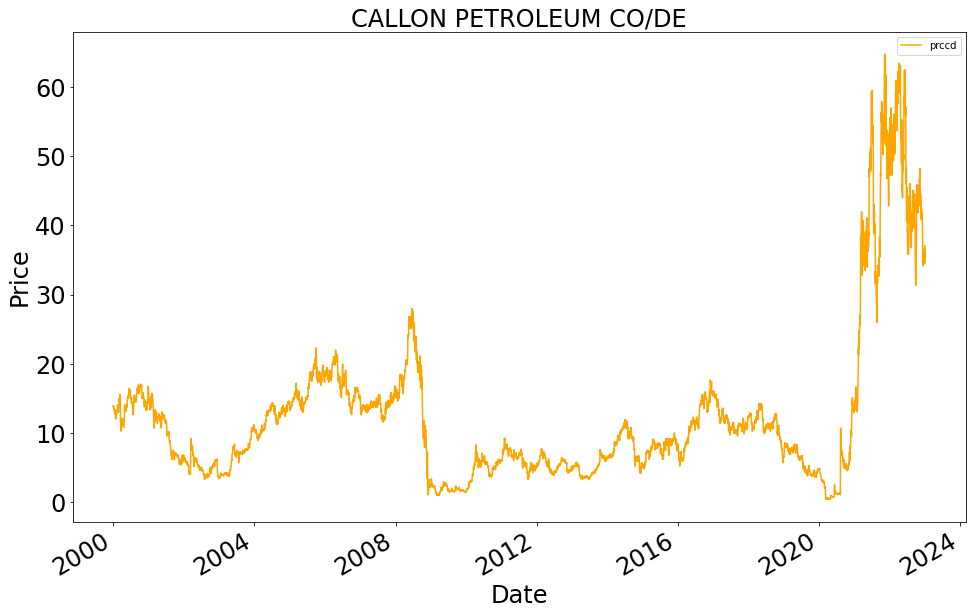

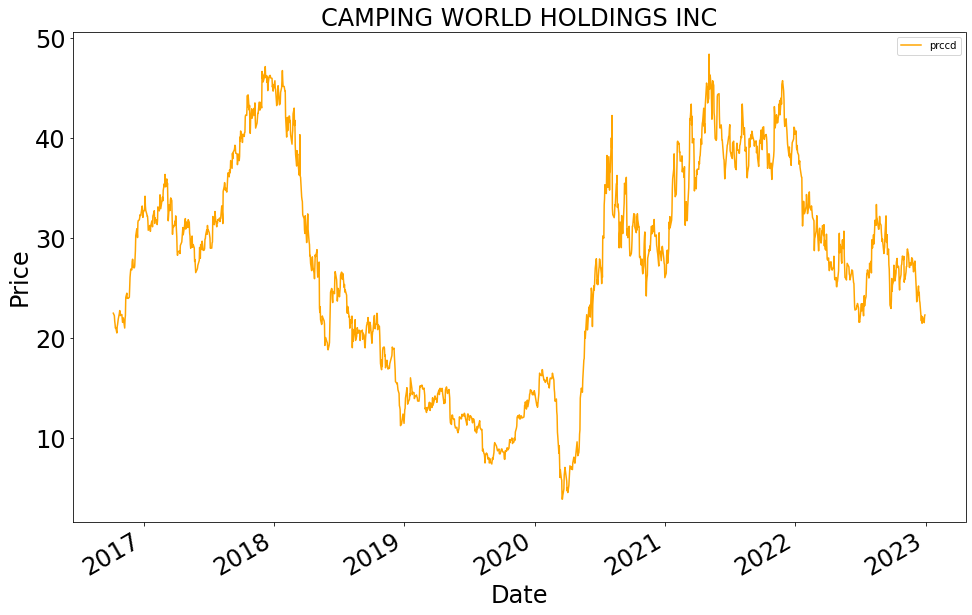

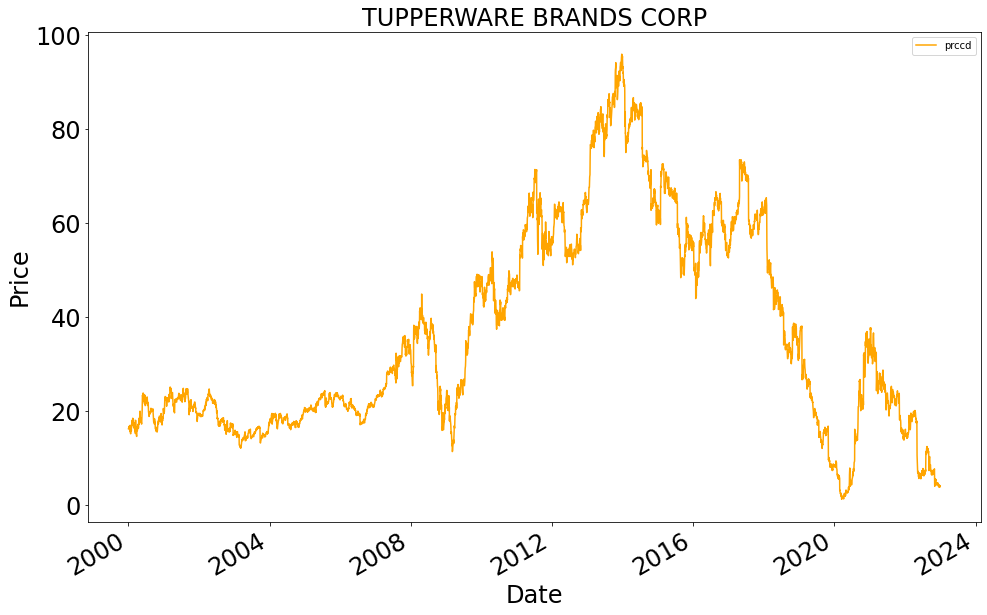

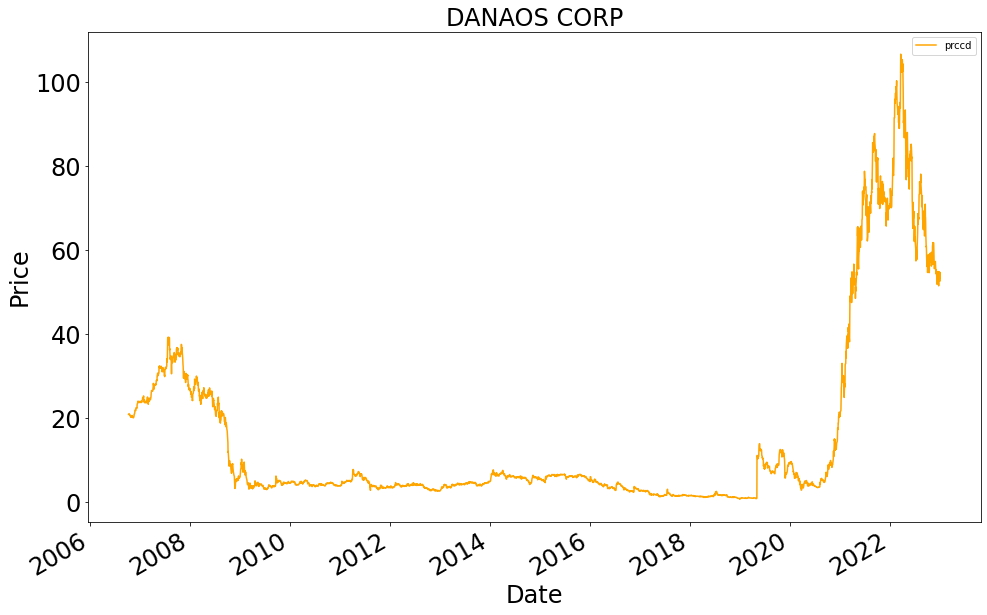

In [132]:
for i in event_outliers_conm:
    #plot adjprice of event outliers
    pdf[pdf['conm'] == i].plot(x='datadate', y=['prccd'], title=i, figsize = (16,10), color='orange')
    plt.title(i, fontsize=fontsize)
    plt.xlabel('Date', fontsize=fontsize)
    plt.ylabel('Price', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.show()

# Nonevent Outliers

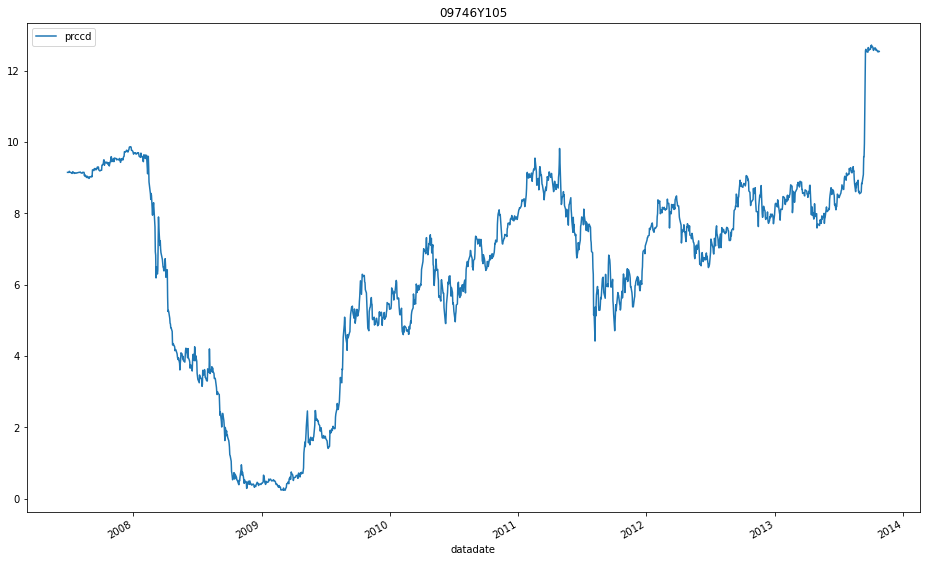

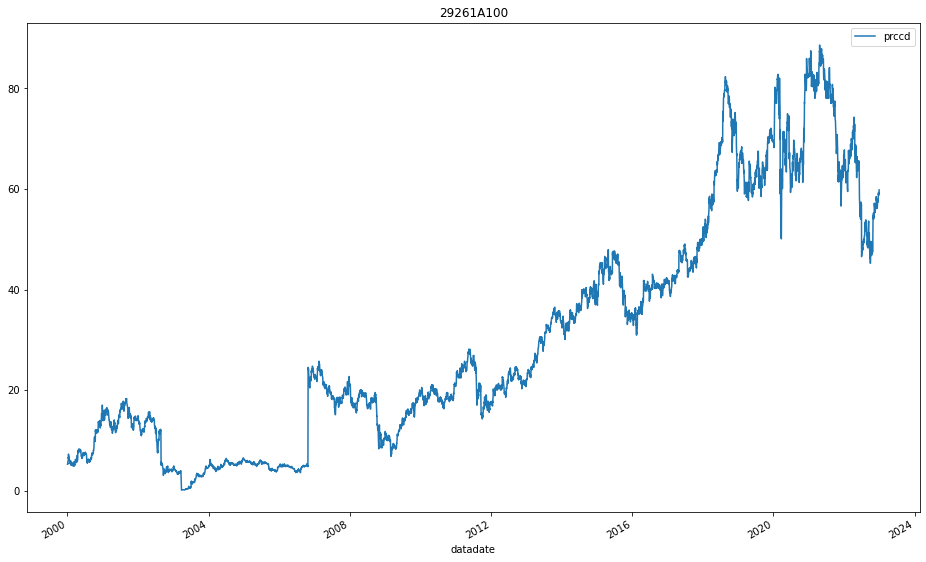

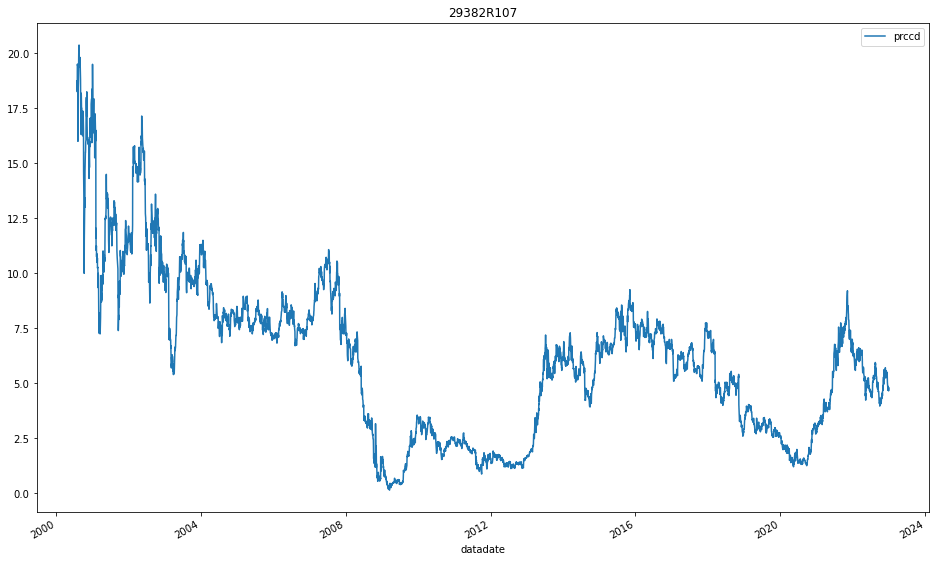

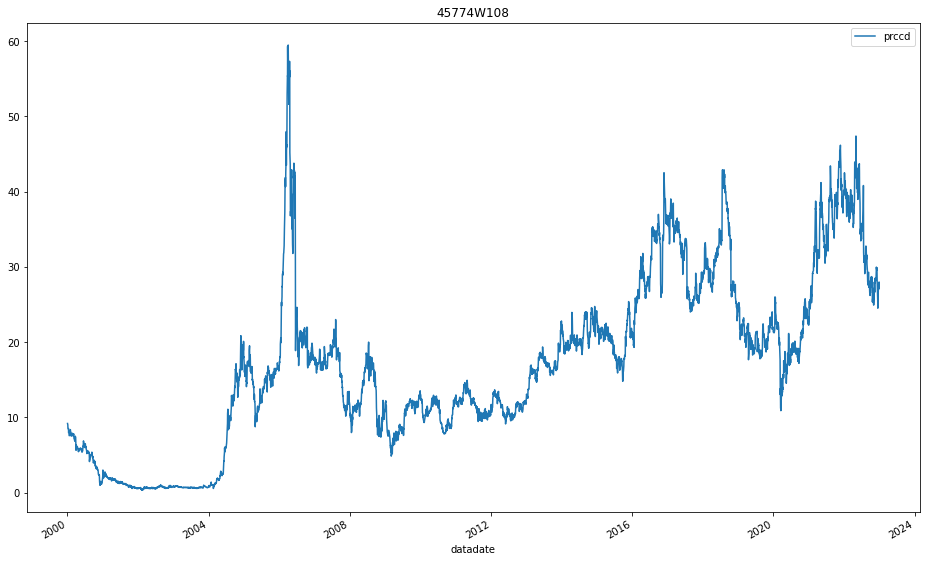

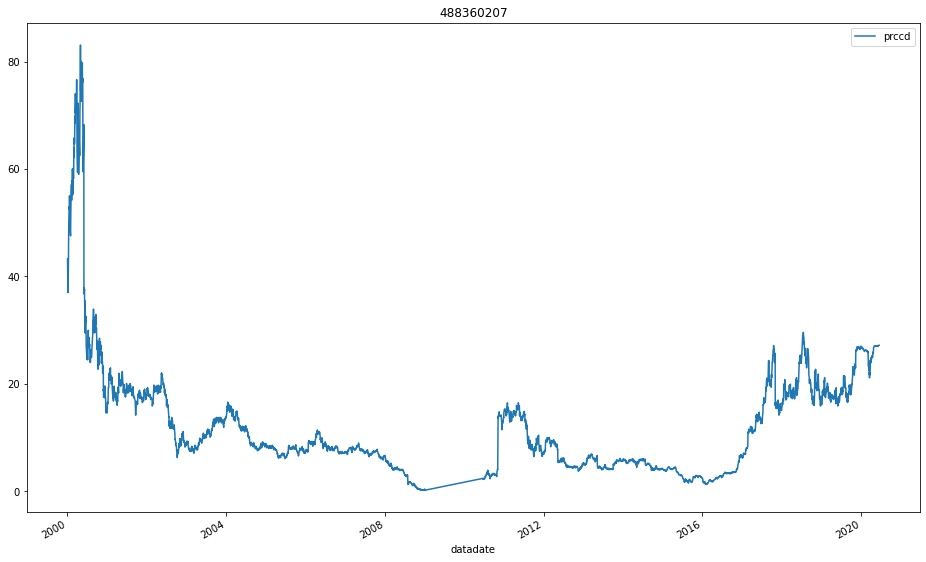

In [133]:
for i in nonevent_outliers_cusip[:5]:
    #plot adjprice of nonevent outliers
    pdf[pdf['cusip'] == i].plot(x='datadate', y=['prccd'], title=i, figsize = (16,10))